In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/CaptstoneProjectData_2024.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())
# Remove unnecessary columns if present
data_cleaned = data.drop(columns=['Unnamed: 2', 'Unnamed: 3'], errors='ignore')

# Replace empty 'Subject' with "EMAIL"
data_cleaned['Subject'] = data_cleaned['Subject'].fillna(' ')

# Check and remove rows with missing 'Body'
data_cleaned = data_cleaned.dropna(subset=['Body'])

# Normalize text: convert to lowercase, remove special characters, and trim whitespaces
data_cleaned['Subject'] = data_cleaned['Subject'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()
data_cleaned['Body'] = data_cleaned['Body'].str.lower().str.replace('[^\w\s]', '', regex=True).str.strip()

# Confirm cleaning
print(data_cleaned.head())


                                             Subject  \
0  ®Review your shipment details / Shipment Notif...   
1                            Υоur ассоunt іѕ оn hоld   
2  Completed: Invoice # KZ89TYS2564 from-Bestbuy....   
3                             UVic IMPORTANT NOTICE!   
4          You have (6) Suspended incoming messages    

                                                Body  Unnamed: 2  Unnamed: 3  
0  Notice: This message was sent from outside the...         NaN         NaN  
1  \r\nVotre réponse a bien été prise en compte.\...         NaN         NaN  
2  Notice: This message was sent from outside the...         NaN         NaN  
3  Your UVIC account has been filed under the lis...         NaN         NaN  
4  \r\n\r\nMessage generated from  uvic.ca source...         NaN         NaN  
                                             Subject  \
0  review your shipment details  shipment notific...   
1                            υоur ассоunt іѕ оn hоld   
2  completed invoice 

In [ ]:
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

def get_most_common_words(text_column, num_words=20):
    # Tokenize the text
    words = nltk.word_tokenize(' '.join(text_column))
    # Remove stopwords
    words = [word for word in words if word not in stop and word.isalpha()]
    # Count the word frequencies
    word_freq = Counter(words)
    return word_freq.most_common(num_words)

# Most common words in Subjects
common_words_subject = get_most_common_words(data_cleaned['Subject'])
# Most common words in Bodies
common_words_body = get_most_common_words(data_cleaned['Body'])

print("Common words in Subjects:", common_words_subject)
print("Common words in Bodies:", common_words_body)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Common words in Subjects: [('spam', 277), ('suspected', 269), ('email', 119), ('notification', 117), ('account', 95), ('hello', 91), ('fw', 89), ('update', 86), ('urgent', 82), ('payment', 81), ('password', 74), ('new', 72), ('order', 69), ('delivery', 66), ('uvicca', 65), ('helpdeskuvicca', 62), ('university', 62), ('victoria', 60), ('action', 58), ('request', 58)]
Common words in Bodies: [('email', 3140), ('please', 2480), ('message', 1915), ('information', 1616), ('sent', 1611), ('university', 1298), ('system', 1262), ('victoria', 1259), ('notice', 1246), ('account', 1232), ('outside', 1118), ('links', 1113), ('sensitive', 1097), ('cautious', 1090), ('dear', 563), ('contact', 536), ('payment', 515), ('address', 501), ('service', 490), ('us', 479)]


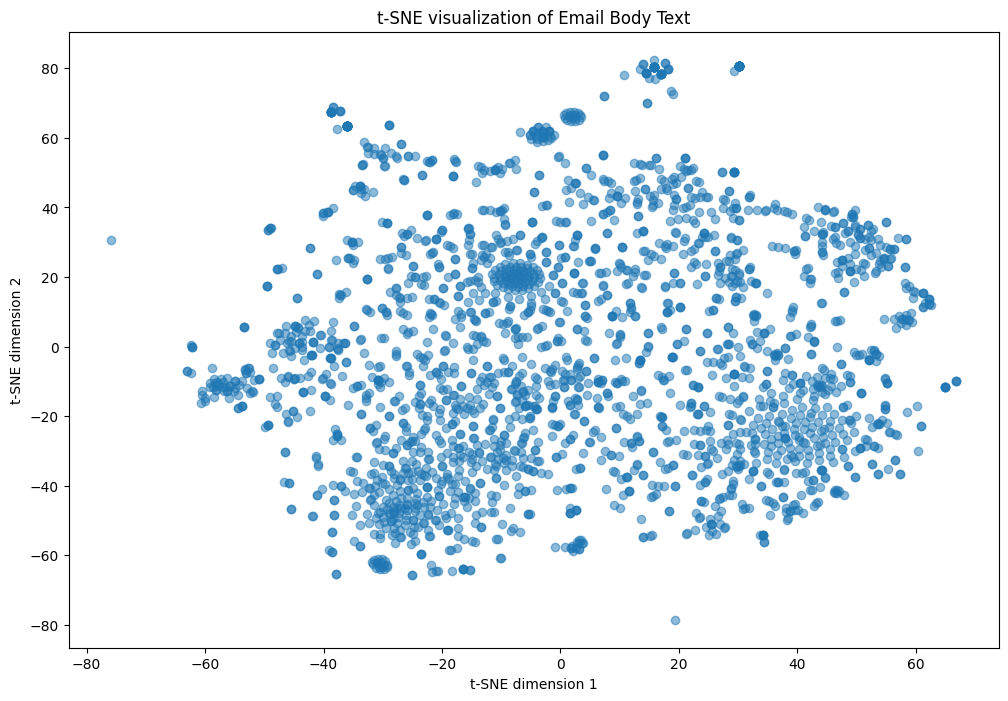

In [ ]:
!pip install scikit-learn matplotlib

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Vectorizing the text data
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limiting to 100 features for simplicity
tfidf_matrix = tfidf_vectorizer.fit_transform(data_cleaned['Body'])

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42)  # Using 2 components for 2D visualization
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# Plotting the results
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of Email Body Text')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()


In [ ]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
import pandas as pd

# Assuming `tsne_results` is your t-SNE output and `data_cleaned` is your dataframe
# Prepare the data for Bokeh
df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['subject'] = data_cleaned['Subject'].values
df_tsne['snippet'] = data_cleaned['Body'].str.slice(0, 50).values  # Take the first 50 characters for the snippet

# Create a ColumnDataSource
source = ColumnDataSource(df_tsne)

# Create the figure
p = figure(min_width=800, min_height=800, title='t-SNE visualization of Email Body Text',
           tools="pan,wheel_zoom,box_zoom,reset")

# Add a hover tool
hover = HoverTool()
hover.tooltips = [("Index", "$index"),
                  ("(x, y)", "(@x, @y)"),
                  ("Subject", "@subject"),
                  ("Snippet", "@snippet")]

p.add_tools(hover)

# Create a scatter plot
p.circle('x', 'y', size=5, source=source, fill_alpha=0.6, line_alpha=0.3)

# Output the file
output_file("tsne_emails.html")

# Show the results
show(p)


In [ ]:
# Example feature: Length of the email body
data_cleaned['Body_Length'] = data_cleaned['Body'].apply(len)

# Example feature: Presence of URLs
data_cleaned['Contains_URL'] = data_cleaned['Body'].str.contains(r'http').astype(int)

# Show the new features
print(data_cleaned[['Body_Length', 'Contains_URL']])
print(data_cleaned['Contains_URL'].count())

      Body_Length  Contains_URL
0             890             1
1            1235             1
2            3024             1
3             528             1
4            1234             1
...           ...           ...
2571          451             1
2572          443             1
2573          428             1
2574          551             1
2575          483             1

[2571 rows x 2 columns]
2571


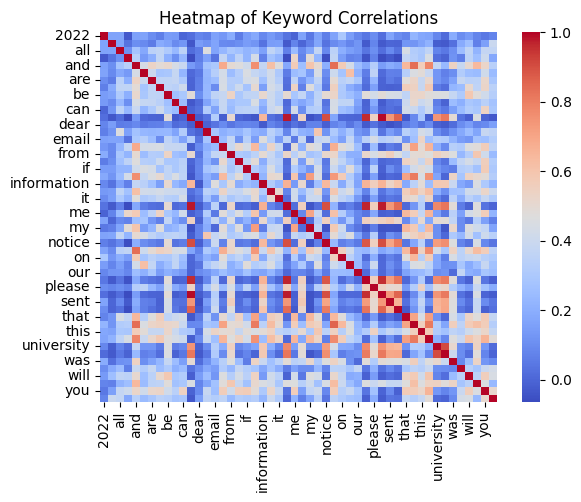

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Create a CountVectorizer instance
vectorizer = CountVectorizer(max_features=50) # You can adjust the number of features
X = vectorizer.fit_transform(data_cleaned['Body'])

# Create a DataFrame with the vectorized data
df_vectorized = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate the correlation matrix
corr_matrix = df_vectorized.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Heatmap of Keyword Correlations')
plt.show()


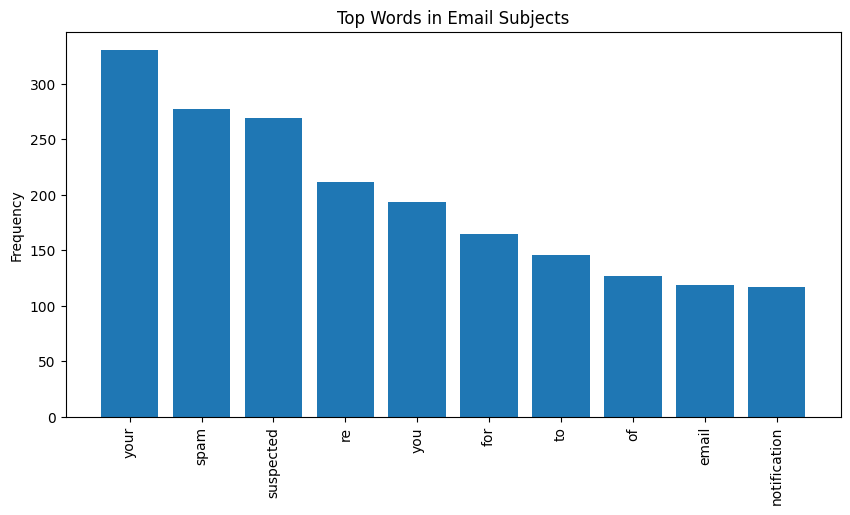

In [ ]:
# Let's assume `subject_freq` is a Counter object of word frequencies.
from collections import Counter

# Count the frequency of words in the 'Subject' column
subject_freq = Counter(" ".join(data_cleaned['Subject']).split()).most_common(10)

# Separate the words and their frequencies
words, freqs = zip(*subject_freq)

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(words, freqs)
plt.title('Top Words in Email Subjects')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


Text(0.5, 0, 'Length of Email')

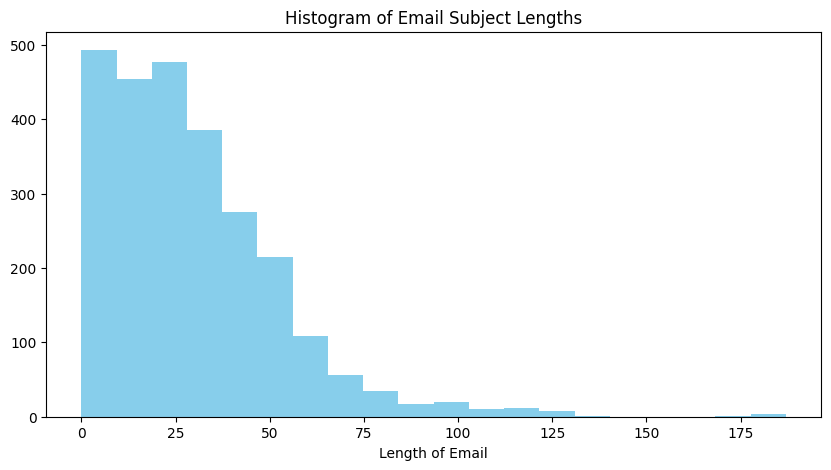

In [ ]:
# Assuming 'Subject_Length' is a column with the length of each email subject
data_cleaned['Subject_Length'] = data_cleaned['Subject'].apply(len)

# Plot a histogram of the email subject lengths
plt.figure(figsize=(10, 5))
plt.hist(data_cleaned['Subject_Length'], bins=20, color='skyblue')
plt.title('Histogram of Email Subject Lengths')
plt.xlabel('Length of Email')


In [ ]:
# Checking for duplicate rows based on all columns
duplicates = data_cleaned.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()

# Print the number of duplicates
num_duplicates

# Check for missing values in the 'Body' column
missing_values_body = data['Body'].isnull().sum()

# Print the number of missing values in the 'Body' column
print(f"Number of missing values in the 'Body' column: {missing_values_body}")

Number of missing values in the 'Body' column: 5
